In [6]:
import pandas as pd
import json
from recipe_scrapers import scrape_me
from recipe_scrapers._schemaorg import SchemaOrg
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn

In [7]:
# pd.read_json('./recipes.json').head(3)
# pd.read_csv('nutrition.csv')

In [8]:

def df_from_list_of_json(srcDf,srcColumn):
    dfs = srcDf[srcColumn].apply(pd.DataFrame)
    megaDf = pd.DataFrame()
    for i,df in enumerate(dfs):
        df.insert(0,'descriptor', srcDf.loc[i,'descriptor'])
        megaDf = pd.concat([megaDf, df])
    return megaDf

recipes = pd.read_json('../data/recipes_01_23.json')
# recipes['descriptor'] = recipes.descriptor.astype(str).str.replace('\xa0',' ')
recipes['mealType'] = recipes.mealType.fillna('')
recipes['mealType'] = recipes.mealType.str.replace('Diner', 'Dinner')

raw_nutrition = df_from_list_of_json(recipes,'nutrition')
raw_nutrition['label'] = raw_nutrition.label.apply(lambda s: s[:-2]).str.lower()  # truncate the colon
raw_nutrition['value'] = raw_nutrition.value.astype(float)
raw_nutrition = raw_nutrition.drop(raw_nutrition[raw_nutrition.label == 'serving'].index)  # drop Serving size entries

# Convert mg to grams
mg_idxs = raw_nutrition.unit=='mg'
raw_nutrition.loc[mg_idxs,'value'] /= 1000
raw_nutrition.loc[mg_idxs,'unit'] = 'g'
raw_nutrition

,descriptor,label,value,unit
1,cheese-enchiladas,calories,589.00000,kcal
2,cheese-enchiladas,carbohydrates,47.00000,g
3,cheese-enchiladas,protein,26.00000,g
4,cheese-enchiladas,fat,34.00000,g
5,cheese-enchiladas,sodium,1.56200,g
...,...,...,...,...
2,garlic-noodles,carbohydrates,62.85000,g
3,garlic-noodles,protein,8.98000,g
4,garlic-noodles,fat,14.23000,g
5,garlic-noodles,sodium,0.26855,g


In [9]:
# turn the macros from the 'label' column into their own columns
nutrition = raw_nutrition.pivot_table('value', columns='label', index=['descriptor'])
# nutrition['descriptor'] = recipes['descriptor']

nutrition.reset_index(inplace=True)
# df_pivot.to_csv('bb_nutrition.csv')
nutrition.sample(5)['descriptor'].astype(str).str.encode('utf-8')

761        b'pumpkin-pie-overnight-oats'
36                b'autumn-quinoa-salad'
177           b'chicken-in-peanut-sauce'
805    b'roasted-cauliflower-taco-bowls'
961        b'spicy-coconut-pumpkin-soup'
Name: descriptor, dtype: object

### One-hot encode the meal types

In [10]:
unique_meal_types = set(
    mealType for mealTypes in recipes.mealType.str.split(",") for mealType in mealTypes
)
mealType = pd.DataFrame(
    {
        mealType: [1 if mealType in cell else 0 for cell in recipes.mealType]
        for mealType in unique_meal_types
    }
)
mealType["descriptor"] = recipes["descriptor"]
mealType.head(2)


,,$1.82,Snack,Bread,Soup,Sandwich,Pasta,condiment,Seasoning,Brunch,...,Salad,Lunch,Dip,Drinks,Breakfast,Appetizer,Side Dish,Sauce,Main Course,descriptor
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,cheese-enchiladas
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,no-sugar-added-apple-pie-overnight-oats


/tmp/ipykernel_6566/2909363922.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seaborn.heatmap(mealType.corr(), linewidths=0.5)


<AxesSubplot: >

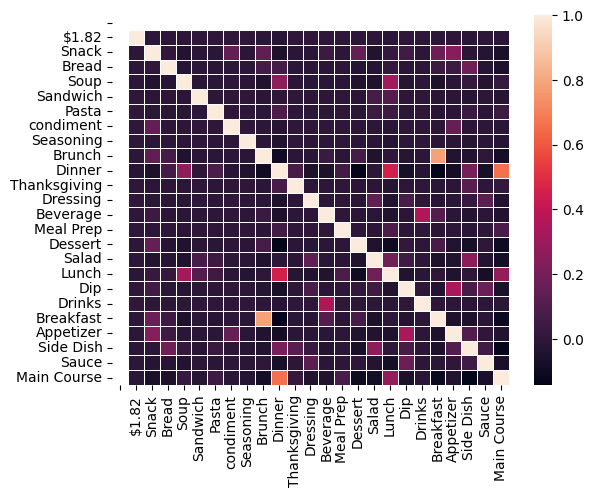

In [11]:
seaborn.heatmap(mealType.corr(), linewidths=0.5)

In [12]:
# recipes.assign(**mealType[['Breakfast','Lunch','Dinner','Snack']].to_dict())
# nutrition.join(mealType,'descriptor')
# nutrition.descriptor
minimalMealType = mealType[['Breakfast','Lunch','Dinner','Snack','descriptor']]
nutritionWithMealType = pd.merge(nutrition, minimalMealType, how='inner', on='descriptor')
nutritionWithMealType = pd.merge(nutritionWithMealType, recipes[['servings','descriptor']], on='descriptor')
nutritionWithMealType.to_csv('bb_nutrition.csv')
nutritionWithMealType


,descriptor,calories,carbohydrates,fat,fiber,protein,sodium,Breakfast,Lunch,Dinner,Snack,servings
0,15-minute-vegetable-curry,97.00,20.00,1.00,6.00,5.00,0.44800,0,1,1,0,5.0
1,16-brunch-recipes-for-easter-and-beyond,119.05,0.55,10.15,0.40,6.25,0.16705,0,0,0,0,2.0
2,20-minute-creamy-spinach-artichoke-pasta,369.63,54.60,11.10,6.53,14.83,1.07975,0,0,0,0,4.0
3,20-minute-honey-mustard-chicken,299.65,8.93,10.70,0.05,38.28,0.58900,0,0,1,0,4.0
4,22-fast-easy-one-pot-meals,484.00,12.00,40.00,5.00,20.00,1.17800,0,1,1,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1146,zucchini-fritters,238.58,13.62,19.28,0.98,3.23,0.11418,0,0,0,0,6.0
1147,zucchini-orzo-salad-chimichurri,422.00,36.00,28.00,4.00,7.00,0.32600,0,1,0,0,4.0
1148,zucchini-pizza-boats,170.15,15.67,8.42,2.83,11.13,0.53218,0,0,0,0,6.0
1149,zucchini-sausage-ravioli,654.45,43.95,41.53,4.68,27.03,1.63235,0,0,0,0,4.0


### Parse time column

In [13]:
time_df = pd.DataFrame(recipes[['descriptor', 'time']])
time_df.time.unique()

array(['15 mins', '8 hrs', '10 mins', '20 mins', '5 mins', '30 mins',
       '1 d 10 mins', '25 mins', '3 mins', '2 hrs 30 mins', '4 mins',
       '2 mins', '40 mins', '45 mins', '', '1 hr 30 mins', '16 hrs',
       '0 mins', '8 mins', '12 mins', '1 hr 15 mins', '1 hr 45 mins',
       '13 hrs', '2 hrs', '8 hrs 10 mins', '8 hrs 30 mins', '1 hr',
       '1 d 30 mins', '12 hrs', '2 hrs 10 mins', '1 d', '2 hrs 20 mins',
       '3 hrs', '50 mins', '35 mins', '18 hrs', '3 hrs 15 mins',
       '4 hrs 20 mins', '4 hrs', '4 hrs 30 mins', '3 hrs 10 mins',
       '2 hrs 15 mins'], dtype=object)

In [14]:
import dateparser
from datetime import datetime
base = datetime.now()
(base - dateparser.parse('1 d', settings={'RELATIVE_BASE':base}))

/mnt/c/Users/David/Documents/Projects/Instacart/venv/lib/python3.9/site-packages/dateparser/freshness_date_parser.py:76: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  now = self.get_local_tz().localize(now)


datetime.timedelta(days=1)

In [15]:
import dateparser
from datetime import datetime
# (datetime.now() - dateparser.parse('12 mins'))
base = datetime.now()
parser = lambda timeString: dateparser.parse(timeString, languages=['en'], settings={'RELATIVE_BASE':base})
time_df['parsedDuration'] = (base - time_df.time.apply(parser))

In [16]:

time_df['durationMins'] = time_df['parsedDuration'].dt.total_seconds() / 60
time_df.durationMins.value_counts()

10.0      372
15.0      276
5.0       253
20.0       93
30.0       43
45.0       20
25.0        7
40.0        7
90.0        7
120.0       6
3.0         6
150.0       5
480.0       5
35.0        4
60.0        4
4.0         4
2.0         4
75.0        4
1080.0      3
720.0       3
1440.0      3
180.0       3
780.0       2
0.0         2
50.0        2
260.0       1
195.0       1
240.0       1
190.0       1
270.0       1
105.0       1
140.0       1
130.0       1
1470.0      1
510.0       1
490.0       1
12.0        1
8.0         1
960.0       1
1450.0      1
135.0       1
Name: durationMins, dtype: int64

In [17]:
time_df[time_df.durationMins < 5]

,descriptor,time,parsedDuration,durationMins
41,easy-buffalo-sauce,3 mins,0 days 00:03:00,3.0
112,funfetti-mug-cake,4 mins,0 days 00:04:00,4.0
114,easy-hollandaise-sauce,2 mins,0 days 00:02:00,2.0
192,apple-cider-mimosas,2 mins,0 days 00:02:00,2.0
244,green-chile-enchilada-sauce,3 mins,0 days 00:03:00,3.0
324,small-batch-crunchy-candied-walnuts,0 mins,0 days 00:00:00,0.0
327,vegan-creamy-mushroom-ramen,3 mins,0 days 00:03:00,3.0
406,vegetable-breakfast-scrambles,3 mins,0 days 00:03:00,3.0
438,all-purpose-garlic-herb-seasoning,2 mins,0 days 00:02:00,2.0
452,make-soft-boiled-eggs,4 mins,0 days 00:04:00,4.0


### Expiriment with generalized scraping library

In [ ]:
scraper = scrape_me('https://www.budgetbytes.com/vegetable-not-fried-rice/')
scraper.schema.category()

'Dinner,Lunch'

In [ ]:
pd.DataFrame(scraper.schema.__dict__)

,format,data
@context,json-ld,http://schema.org/
@type,json-ld,Recipe
aggregateRating,json-ld,"{'@type': 'AggregateRating', 'ratingValue': '4..."
author,json-ld,"{'@type': 'Person', 'name': 'Beth - Budget Byt..."
cookTime,json-ld,PT12M
datePublished,json-ld,2022-03-30T07:31:00+00:00
description,json-ld,"Vegetable Fried Rice is a fast, easy, deliciou..."
image,json-ld,[https://www.budgetbytes.com/wp-content/upload...
keywords,json-ld,"Fried Rice, vegetable fried rice, vegetarian f..."
name,json-ld,Vegetable Fried Rice


In [ ]:
scraper.schema.cook_time()

12

In [ ]:
scraper.schema.data.get("recipeCategory")

['Dinner', 'Lunch']

In [ ]:
data = open('../data/vegetable-not-fried-rice.html').read()
soup = BeautifulSoup(data, "html.parser")
SchemaOrg(str(soup.html)).category()

'Dinner,Lunch'

In [ ]:
scraper.schema.nutrients()

{'servingSize': '1.25 cups',
 'calories': '371 kcal',
 'carbohydrateContent': '44 g',
 'proteinContent': '10 g',
 'fatContent': '17 g',
 'sodiumContent': '807 mg',
 'fiberContent': '4 g'}

In [ ]:
scraper.schema.ratings()

4.95